# Seq2Seq Modeling with nn.Transformer and torchtext

이번 실습에서는 `nn.Transformer` 모듈을 이용하여 seq2seq 모델을 학습하는 방법을 배워보겠습니다.

PyTorch 1.2 버젼에는 Attention is All You Need 논문에 기반한 표준 transformer 모듈을 포함하고 있습니다. `nn.Transformer` 모듈은 input과 output 사이의 global dependency를 나타내기 위하여 전적으로 attention 메커니즘만을 사용합니다. Transformer 모델은 더 높은 수준의 병렬화가 가능하면서도 많은 seq2seq 문제들에서 높은 성능을 보였습니다. 

# 0. Requirements

In [2]:
!pip3 install torchtext==0.4.0

     |████████████████████████████████| 53 kB 1.2 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0


# 1. Transformer Encoder Model

본 실습에서, 우리는 `nn.TransformerEncoder` 모델을 language modeling task에 대해서 학습시킬 것입니다. Language modeling은 주어진 단어 (또는 단어 sequence) 가 다음에 이어지는 단어 sequence를 따를 가능성(likelihood)에 대한 확률을 할당하는 task입니다. 

먼저, 토큰들의 sequence가 embedding layer에서 embedding vector로 만들어지고 positional encoding layer에서 각 단어의 position에 대한 정보를 추가합니다.

`nn.TransformerEncoder`는 여러 개의 `nn.TransformerEncoderLayer`로 구성되어 있습니다. 각 layer들은 self-attention을 사용하여 encode합니다.

실제 단어를 얻기 위해서, `nn.TransformerEncoder`의 output은 log-Softmax 로 이어지는 최종 linear layer로 전달 됩니다.

아래의 그림은 Transformer의 전체 구조를 보여주고 있으며 본 실습에서 사용되는 부분은 왼쪽의 encoder 부분입니다.

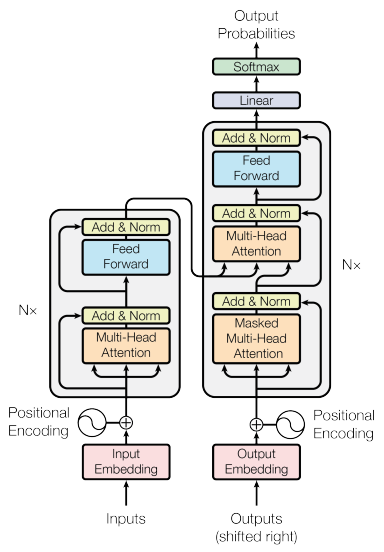

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()
    
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

### 연습
이번 실습에서는 Transformer와 RNN 모델의 성능을 비교할 것입니다.
이를 위한 RNN 모델을 완성시켜봅시다.

In [4]:
class RNNModel(nn.Module):
    def __init__(self, ntoken, ninp, dropout=0.5):
        super(RNNModel, self).__init__()
        self.model_type = 'RNN'
        self.hidden_size = ninp
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        ## Start your code
        self.rnn_encoder = nn.GRU(ninp, ninp)
        self.decoder = nn.Linear(ninp, ntoken)
        ##End your code

        self.init_weights()           

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, hidden):
        src = self.encoder(src) * math.sqrt(self.ninp)
        ## Start your code
        output, hidden = self.rnn_encoder(src, hidden)
        output = self.decoder(output)
        ##End your code
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

`PositionalEncoding` 모듈은 sequence 내에서 토큰의 위치에 대한 정보를 주입합니다. Positional encoding은 embedding과 합칠 수 있도록 똑같은 dimension을 가집니다. 여기에서, 우리는 다른 주파수의 sine과 cosine 함수를 사용합니다

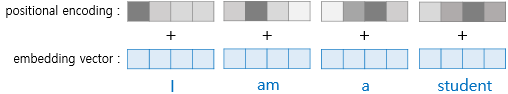

$$PE_{(pos, 2i)}=sin(pos/100000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)}=cos(pos/100000^{2i/d_{model}})$$

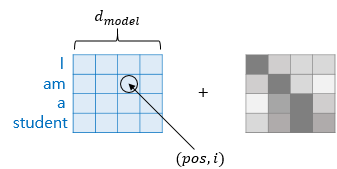

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# 2. Load and Batch Data

학습에서는 `torchtext`의 Wikitext-2 데이터셋을 이용합니다. `vocab` 오브젝트는 train 데이터셋에 의하여 만들어지고, 토큰을 tensor로 수치화하는데 사용됩니다. Sequence 데이터로부터 시작하여, `batchify()` 함수는 데이터셋을 column으로 정렬하고, `batch_size`의 배치들로 나눈 후에 남은 모든 토큰을 버립니다. 예를 들어, 알파벳을 시퀀스(총 길이 26) 로 생각하고 배치 사이즈를 4라고 한다면, 우리는 알파벳을 길이가 6인 4개의 시퀀스로 나눌 수 있습니다.

$$
\left[\begin{array}{rrrrrrr} 
A&B&C&...&X&Y&Z
\end{array}
\right]
\Rightarrow
\left[\begin{array}{rrrr} 
  \left[\begin{array}{r} 
  A\\B\\C\\D\\E\\F
  \end{array}\right]
  \left[\begin{array}{r} 
  G\\H\\I\\J\\K\\L
  \end{array}\right]
  \left[\begin{array}{r} 
  M\\N\\O\\P\\Q\\R
  \end{array}\right]
  \left[\begin{array}{r} 
  S\\T\\U\\V\\W\\X
  \end{array}\right]
\end{array}\right]$$

이 column들은 모델에 의해서 독립적으로 취급되며, 이것은 G 와 F 의 의존성이 학습될 수 없다는 것을 의미합니다. 더 나은 batch 프로세싱이 가능하지만, 이 경우 batch 프로세싱이 복잡해지므로 생략합니다.

다음은 아래의 코드를 실행시켰을때의 결과의 예시입니다.

Out:
```
downloading wikitext-2-v1.zip
wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:01<00:00, 3.09MB/s]
extracting
```

In [6]:
import torchtext
from torchtext.data.utils import get_tokenizer

TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # 데이터셋을 bsz로 나눕니다.
    nbatch = data.size(0) // bsz
    # 깔끔하게 나누어 떨어지지 않는 추가적인 부분(나머지들) 은 잘라냅니다.
    data = data.narrow(0, 0, nbatch * bsz)
    # 데이터에 대하여 bsz 배치들로 동등하게 나눕니다.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 20.2MB/s]


extracting


# 3. Functions to Generate Input and Target Sequence

`get_batch()` 함수는 Transformer 모델을 위한 input과 target sequence를 생성합니다. 이 함수는 소스 데이터를 `bptt` 길이를 가진 덩어리로 세분화 합니다. Language modeling을 위해서, 모델은 다음 단어인 `Target`이 필요 합니다. 예를 들어, `bptt`의 값이 2 라면, 우리는 `i` = 0 일 때 다음의 2 개의 변수를 얻을 수 있습니다:

`input`= 
$\left[\begin{array}{r} 
  \left[\begin{array}{rrrr} 
  A&G&M&S
  \end{array}\right]\\
  \left[\begin{array}{rrrr} 
  B&H&N&T
  \end{array}\right]
\end{array}\right]$

`target`=
$\left[\begin{array}{r}
  \left[\begin{array}{rrrr} 
  B&H&N&T
  \end{array}\right]\\
  \left[\begin{array}{rrrr} 
  C&I&O&U
  \end{array}\right]
\end{array}\right]$

In [7]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    input = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return input, target

# 4. Initiate an Instance
모델은 아래와 같은 하이퍼파라미터로 세팅 됩니다.

In [8]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value 

model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
rnn_model = RNNModel(ntokens, emsize, dropout).to(device)

# 5. Run the Model
Loss는 `CrossEntropyLoss`가 사용되며, optimizer는 `SGD`를 사용합니다. Learning rate는 5.0으로 설정됩니다. `StepLR`은 epoch에 따라서 학습률을 조절하는데 사용됩니다. 학습하는 동안에, gradient exploding을 방지하기 위하여 모든 기울기를 함께 scale하는 함수인 `nn.utils.clip_grad_norm_`을 이용합니다.

다음은 RNN 모델을 train하는 함수입니다.

In [9]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
rnn_optimizer = torch.optim.SGD(rnn_model.parameters(), lr=lr)
rnn_scheduler = torch.optim.lr_scheduler.StepLR(rnn_optimizer, 1.0, gamma=0.95)

import time
def train_rnn(epoch):
    rnn_model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    hidden=rnn_model.initHidden(batch_size)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        loss = 0
        data, targets = get_batch(train_data, i)
        rnn_optimizer.zero_grad()
        output, hidden = rnn_model(data, hidden)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), 0.5)
        rnn_optimizer.step()

        hidden = hidden.detach()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, rnn_scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate_rnn(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    hidden=eval_model.initHidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = eval_model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

In [10]:
data, targets = get_batch(train_data, 0)

In [11]:
data.size(), targets.size()

(torch.Size([35, 20]), torch.Size([700]))

### 연습
위의 함수를 참고하여 Transformer 모델을 학습하는 함수를 완성해봅시다.

In [12]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train(epoch):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    ## Start your code    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        ##End your code  

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Epoch를 반복합니다. 만약 validation loss가 우리가 지금까지 관찰한 것 중 최적의 값이라면 모델을 저장합니다. 매 epoch이 끝날 때마다 learning rate를 조절합니다.

학습 과정에서 출력되는 `ppl`은 perplexity의 약자입니다. Perplexity는 language model을 평가하는 지표로 다음과 같이 정의됩니다.

$$
PPL(w_1,...,w_n)=P(w_1,...,w_n)^{-\frac{1}{n}}
$$

일반적으로 perplexity가 낮을수록 좋은 성능을 가집니다. 풀어서 설명하자면 perplexity는 language model이 다음 단어를 예측할때마다 몇 개의 후보들 중에서 답을 고민하는지를 의미합니다. 만약 PPL이 10이면 평균적으로 langauage model이 다음 단어로 10개의 단어 중에 고민하고 있음을 의미합니다.


In [13]:
def trainIters(model, train, evaluate):
  best_val_loss = float("inf")
  epochs = 5 # The number of epochs
  best_model = None

  for epoch in range(1, epochs + 1):
      epoch_start_time = time.time()
      train(epoch)
      val_loss = evaluate(model, val_data)
      print('-' * 89)
      print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
            'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                      val_loss, math.exp(val_loss)))
      print('-' * 89)

      if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_model = model

      scheduler.step()
  return best_model

먼저 RNN 모델을 학습시켜 봅시다.

In [14]:
rnn_best_model = trainIters(rnn_model, train_rnn, evaluate_rnn)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |   200/ 2981 batches | lr 5.00 | ms/batch 37.16 | loss  6.95 | ppl  1044.85
| epoch   1 |   400/ 2981 batches | lr 5.00 | ms/batch 36.19 | loss  6.15 | ppl   467.35
| epoch   1 |   600/ 2981 batches | lr 5.00 | ms/batch 36.16 | loss  5.82 | ppl   337.86
| epoch   1 |   800/ 2981 batches | lr 5.00 | ms/batch 36.09 | loss  5.73 | ppl   307.94
| epoch   1 |  1000/ 2981 batches | lr 5.00 | ms/batch 36.03 | loss  5.62 | ppl   276.96
| epoch   1 |  1200/ 2981 batches | lr 5.00 | ms/batch 36.02 | loss  5.60 | ppl   270.62
| epoch   1 |  1400/ 2981 batches | lr 5.00 | ms/batch 35.99 | loss  5.57 | ppl   262.01
| epoch   1 |  1600/ 2981 batches | lr 5.00 | ms/batch 36.05 | loss  5.61 | ppl   272.38
| epoch   1 |  1800/ 2981 batches | lr 5.00 | ms/batch 36.11 | loss  5.48 | ppl   240.44
| epoch   1 |  2000/ 2981 batches | lr 5.00 | ms/batch 35.95 | loss  5.47 | ppl   237.43
| epoch   1 |  2200/ 2981 batches | lr 5.00 | ms/batch 35.96 | loss  5.34 | ppl   207.88
| epoch   1 |  2400/ 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


| epoch   2 |   200/ 2981 batches | lr 5.00 | ms/batch 36.05 | loss  5.27 | ppl   194.20
| epoch   2 |   400/ 2981 batches | lr 5.00 | ms/batch 35.88 | loss  5.26 | ppl   192.69
| epoch   2 |   600/ 2981 batches | lr 5.00 | ms/batch 35.90 | loss  5.01 | ppl   150.56
| epoch   2 |   800/ 2981 batches | lr 5.00 | ms/batch 35.95 | loss  5.06 | ppl   158.22
| epoch   2 |  1000/ 2981 batches | lr 5.00 | ms/batch 35.85 | loss  5.01 | ppl   150.59
| epoch   2 |  1200/ 2981 batches | lr 5.00 | ms/batch 35.98 | loss  5.04 | ppl   154.23
| epoch   2 |  1400/ 2981 batches | lr 5.00 | ms/batch 36.10 | loss  5.06 | ppl   158.12
| epoch   2 |  1600/ 2981 batches | lr 5.00 | ms/batch 36.03 | loss  5.13 | ppl   169.75
| epoch   2 |  1800/ 2981 batches | lr 5.00 | ms/batch 35.99 | loss  5.04 | ppl   153.78
| epoch   2 |  2000/ 2981 batches | lr 5.00 | ms/batch 35.99 | loss  5.04 | ppl   154.29
| epoch   2 |  2200/ 2981 batches | lr 5.00 | ms/batch 35.98 | loss  4.90 | ppl   134.94
| epoch   2 |  2400/ 

이번에는 Transformer 모델을 학습시켜 봅시다.

In [15]:
tr_best_model = trainIters(model, train, evaluate)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |   200/ 2981 batches | lr 3.68 | ms/batch 43.92 | loss  8.09 | ppl  3246.09
| epoch   1 |   400/ 2981 batches | lr 3.68 | ms/batch 43.50 | loss  7.08 | ppl  1185.77
| epoch   1 |   600/ 2981 batches | lr 3.68 | ms/batch 43.69 | loss  6.56 | ppl   707.60
| epoch   1 |   800/ 2981 batches | lr 3.68 | ms/batch 43.72 | loss  6.35 | ppl   570.41
| epoch   1 |  1000/ 2981 batches | lr 3.68 | ms/batch 43.43 | loss  6.16 | ppl   473.99
| epoch   1 |  1200/ 2981 batches | lr 3.68 | ms/batch 43.56 | loss  6.11 | ppl   450.36
| epoch   1 |  1400/ 2981 batches | lr 3.68 | ms/batch 43.35 | loss  6.04 | ppl   418.74
| epoch   1 |  1600/ 2981 batches | lr 3.68 | ms/batch 43.51 | loss  6.03 | ppl   414.84
| epoch   1 |  1800/ 2981 batches | lr 3.68 | ms/batch 43.44 | loss  5.93 | ppl   374.72
| epoch   1 |  2000/ 2981 batches | lr 3.68 | ms/batch 43.54 | loss  5.92 | ppl   371.65
| epoch   1 |  2200/ 2981 batches | lr 3.68 | ms/batch 43.52 | loss  5.80 | ppl   328.71
| epoch   1 |  2400/ 

# 6. Evaluate the Model with the Test Dataset
Evaluate에는 best model이 사용됩니다.


In [16]:
rnn_test_loss = evaluate_rnn(rnn_best_model, test_data)
tr_test_loss = evaluate(tr_best_model, test_data)
print('=' * 88)
print('| RNN Model\t\t| test loss {:5.2f} | test ppl {:8.2f}'.format(
    rnn_test_loss, math.exp(rnn_test_loss)))
print('=' * 88)
print('| Transformer Model\t| test loss {:5.2f} | test ppl {:8.2f}'.format(
    tr_test_loss, math.exp(tr_test_loss)))
print('=' * 88)

| RNN Model		| test loss  5.25 | test ppl   190.05
| Transformer Model	| test loss  5.19 | test ppl   179.04
